In [7]:
import corner
import arviz as az
import matplotlib.pyplot as plt
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [8]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [9]:
t, flux = np.loadtxt(datadir("exoplanet_gen.dat"), unpack=True)

In [30]:
with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(3.5), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # getting t0 accurate is super important for map solution working
    t0 = pm.Normal("t0", sd=5, testval=1.3)

    us = xo.distributions.QuadLimbDark("us")

    r = pm.Uniform("r", lower=0.01, upper=0.1)
    loga = pm.Normal("loga", mu=np.log(10), sd=0.1)
    a = pm.Deterministic("a", pm.math.exp(loga))

    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, a=a)

    y = xo.LimbDarkLightCurve(us).get_light_curve(
        orbit=orbit, r=r, t=t
    )[:, 0] + 1
    pm.Deterministic("y", y)
    yerr = pm.HalfCauchy("yerr", 0.1)
    pm.Normal("obs", mu=y, sd=yerr, observed=flux)

In [31]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [yerr, loga, r, us, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 19919.26496573362 -> 112117.38564319757


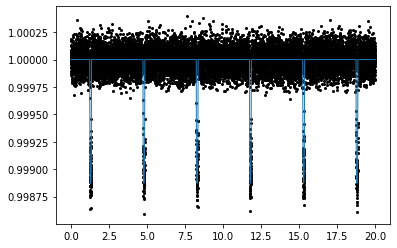

In [32]:
import matplotlib.pyplot as plt
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [33]:
np.random.seed(8462852)
with model:
    trace = pm.sample(
        tune=5000,
        draws=10000,
        step=pm.Metropolis(),
        start=map_soln,
        cores=4,
        chains=4,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [yerr]
INFO:pymc3:>Metropolis: [yerr]
>Metropolis: [loga]
INFO:pymc3:>Metropolis: [loga]
>Metropolis: [r]
INFO:pymc3:>Metropolis: [r]
>Metropolis: [us]
INFO:pymc3:>Metropolis: [us]
>Metropolis: [t0]
INFO:pymc3:>Metropolis: [t0]
>Metropolis: [logP]
INFO:pymc3:>Metropolis: [logP]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 166 seconds.
INFO:pymc3:Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 166 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [34]:
var_names = ["period", "t0", "r", "a", "us", "yerr"]
with model:
    summary = az.summary(trace, var_names=var_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,3.500,0.000,3.500,3.500,0.000,0.000,1392.0,2831.0,1.01
t0,1.300,0.000,1.300,1.301,0.000,0.000,1441.0,2615.0,1.01
r,0.030,0.000,0.030,0.030,0.000,0.000,993.0,1818.0,1.00
a,10.036,0.032,9.978,10.097,0.001,0.001,687.0,1422.0,1.00
us[0],0.496,0.063,0.373,0.609,0.002,0.002,778.0,1591.0,1.00
us[1],0.171,0.111,-0.038,0.373,0.005,0.003,565.0,839.0,1.00
yerr,0.000,0.000,0.000,0.000,0.000,0.000,7256.0,7212.0,1.00


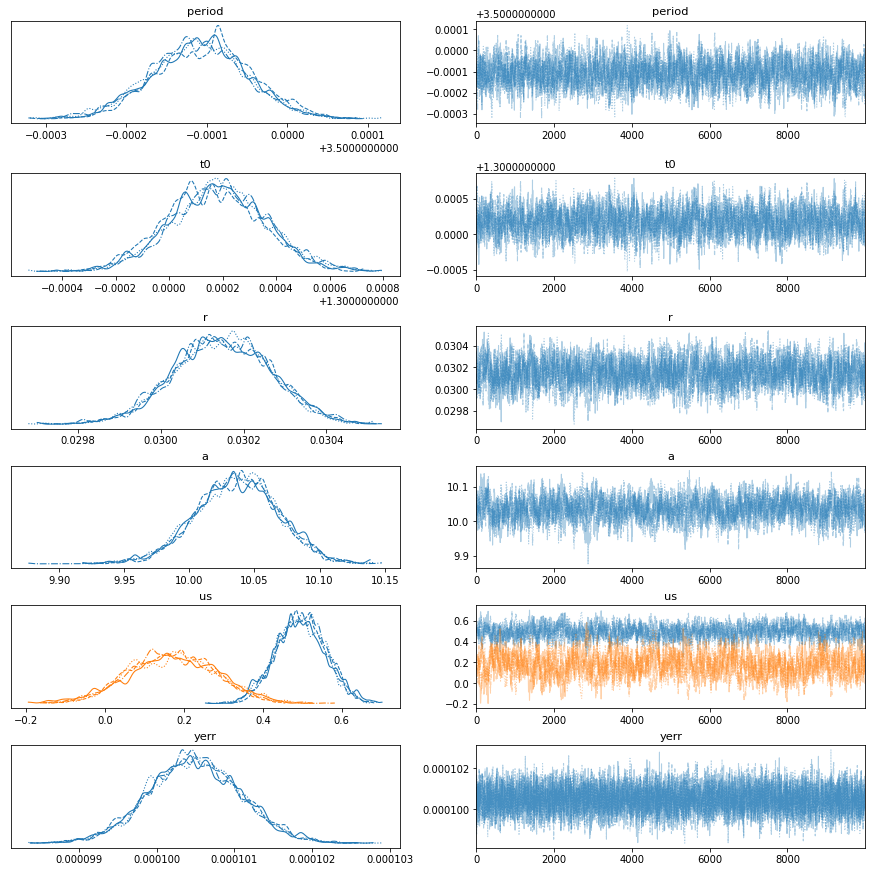

In [35]:
with model:
    az.plot_trace(trace, var_names=var_names);

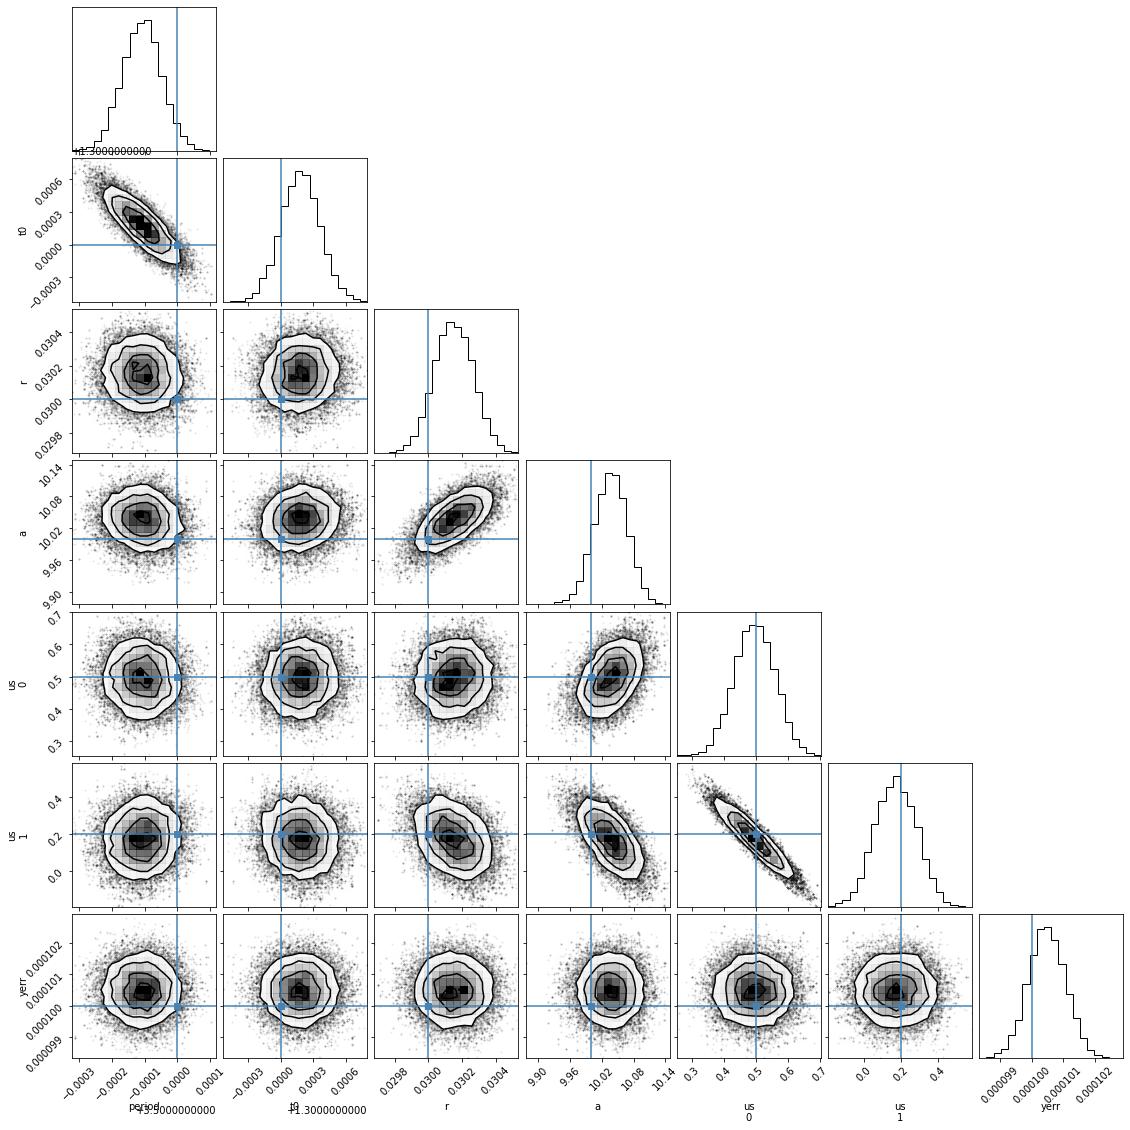

In [44]:
truth = [3.5, 1.3, 0.03, 10, 0.5, 0.2, 1e-4]
_ = corner.corner(
    trace,
    var_names=var_names,
    truths=truth,
)

In [47]:
# Get the posterior median orbital parameters
p = np.median(trace["posterior"]["period"])
Pmean = np.mean(trace["posterior"]["period"]).values
Pstd = np.std(trace["posterior"]["period"]).values
t0 = np.median(trace["posterior"]["t0"])
pred = trace["posterior"]["y"]
pred = np.median(pred, axis=(0, 1))

In [72]:
true_orbit = xo.orbits.KeplerianOrbit(period=3.5, t0=1.3, a=10)
true_mod = xo.LimbDarkLightCurve([0.5, 0.2]).get_light_curve(orbit=true_orbit, r=0.03, t=t)[:, 0].eval() + 1

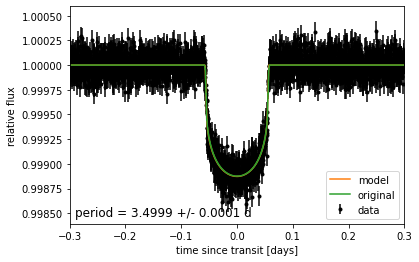

In [73]:
# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(
    x_fold, flux, yerr=1e-4, fmt=".k", label="data", zorder=-1000
)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
plt.plot(x_fold[inds], pred[inds], color="C1", label="model")
plt.plot(x_fold[inds], true_mod[inds], color="C2", label="original")

# Annotate the plot with the planet's period
txt = f"period = {Pmean:.4f} +/- {Pstd:.4f} d"
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.xlim(-0.3, 0.3);

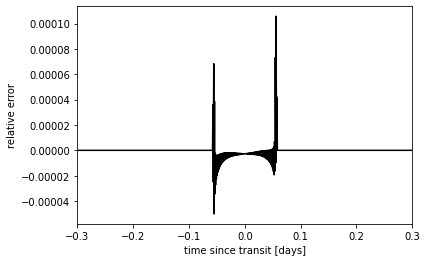

In [74]:
# Plot the folded model residuals
plt.plot(x_fold[inds], pred[inds]/ true_mod[inds] - 1, color="k")
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative error")
plt.xlim(-0.3, 0.3);